In [5]:
# Phase 1: Data Preparation for Book Recommendation System

import pandas as pd

# 1. Load Dataset from Local Path
file_path = r"C:\Users\ratnakar\Downloads\Audible_Catalog.csv"  
df = pd.read_csv(file_path)

# 2. Quick Overview
print("Initial shape of dataset:", df.shape)
print("Columns:", df.columns)
print("\nSample data:")
print(df.head())

# 3. Drop Duplicate Records (based on Book Name and Author)
df = df.drop_duplicates(subset=['Book Name', 'Author'])
print("\nShape after dropping duplicates:", df.shape)

# 4. Handle Missing Values
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Drop rows with missing essential fields
df = df.dropna(subset=['Book Name', 'Author', 'Description', 'Rating'])

# Fill non-critical missing fields with defaults
df['Price'] = df['Price'].fillna(0)
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)
df['Listening Time'] = df['Listening Time'].fillna('Unknown')
df['Ranks and Genre'] = df['Ranks and Genre'].fillna('Unknown')

print("\nMissing values after cleaning:")
print(df.isnull().sum())

# 5. Standardize and Format Columns

# Convert numeric columns
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Number of Reviews'] = pd.to_numeric(df['Number of Reviews'], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Format text columns
df['Book Name'] = df['Book Name'].str.strip().str.title()
df['Author'] = df['Author'].str.strip().str.title()

# 6. Final Summary
print("\nCleaned Dataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

# Optional: Save cleaned data
df.to_csv("C:/Users/ratnakar/Downloads/cleaned_audible_catalog.csv", index=False)
print("\nCleaned dataset saved as 'cleaned_audible_catalog.csv'")

Initial shape of dataset: (4464, 8)
Columns: Index(['Book Name', 'Author', 'Rating', 'Number of Reviews', 'Price',
       'Description', 'Listening Time', 'Ranks and Genre'],
      dtype='object')

Sample data:
                                           Book Name          Author  Rating  \
0  Think Like a Monk: The Secret of How to Harnes...      Jay Shetty     4.9   
1  Ikigai: The Japanese Secret to a Long and Happ...   HÃ©ctor GarcÃ­a     4.6   
2  The Subtle Art of Not Giving a F*ck: A Counter...     Mark Manson     4.4   
3  Atomic Habits: An Easy and Proven Way to Build...     James Clear     4.6   
4  Life's Amazing Secrets: How to Find Balance an...  Gaur Gopal Das     4.6   

   Number of Reviews  Price  \
0              371.0  10080   
1             3682.0    615   
2            20306.0  10378   
3             4678.0    888   
4             4308.0   1005   

                                         Description           Listening Time  \
0  Over the past three years, Jay Shet

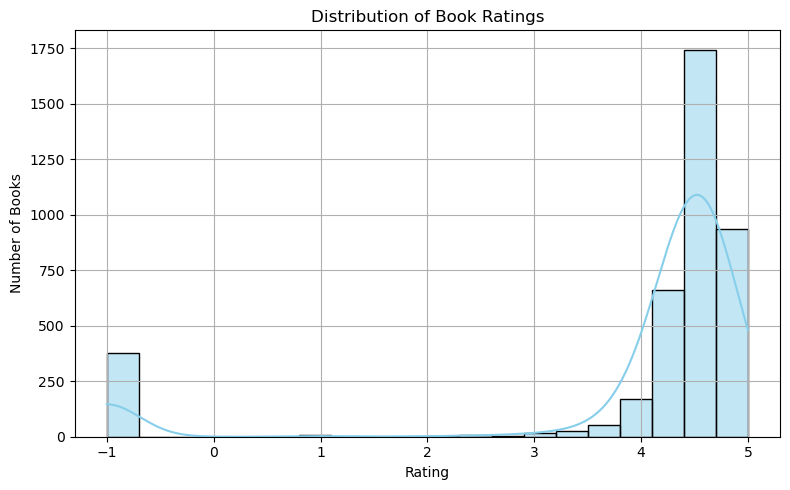

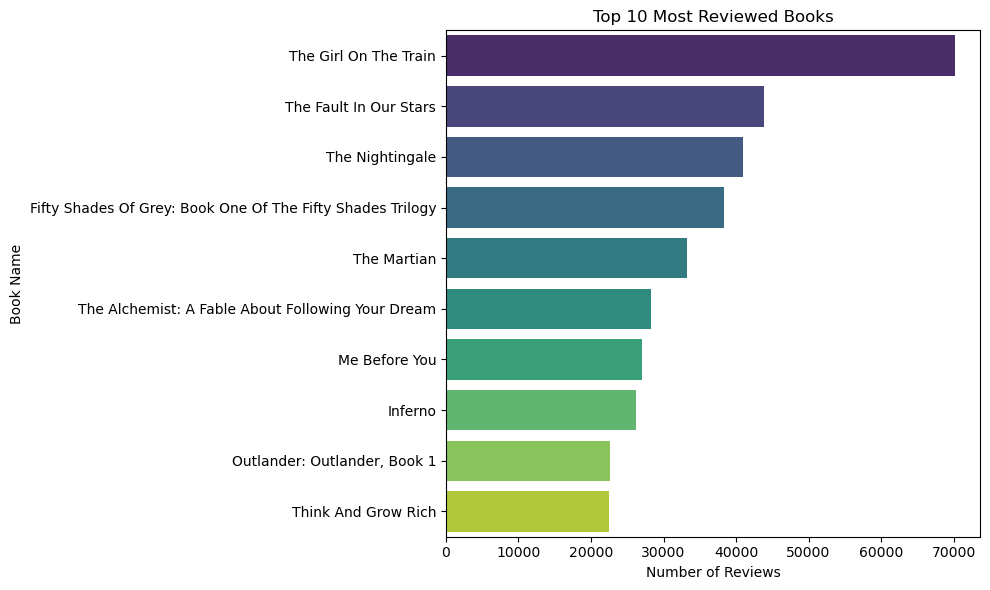

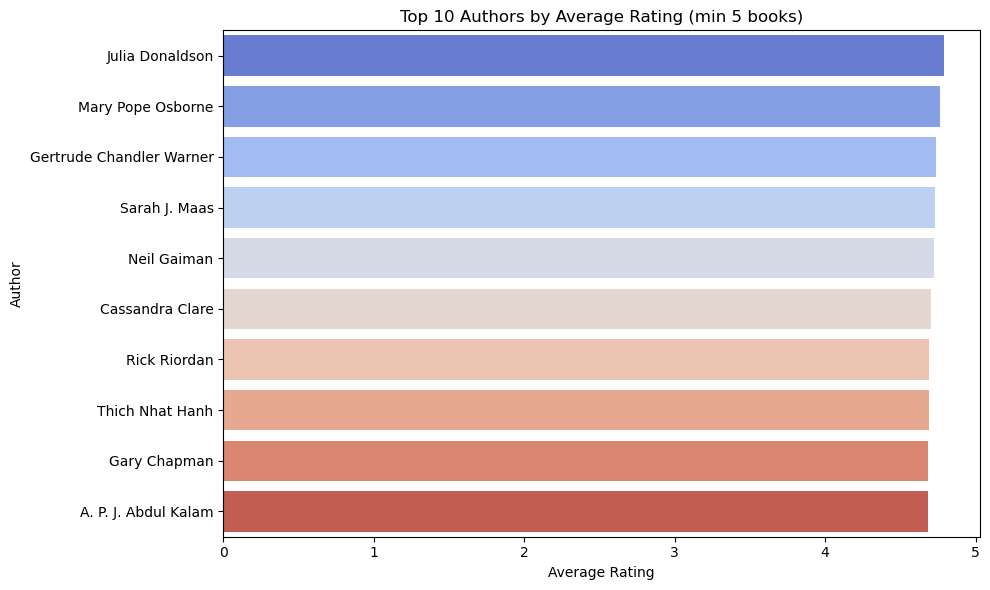

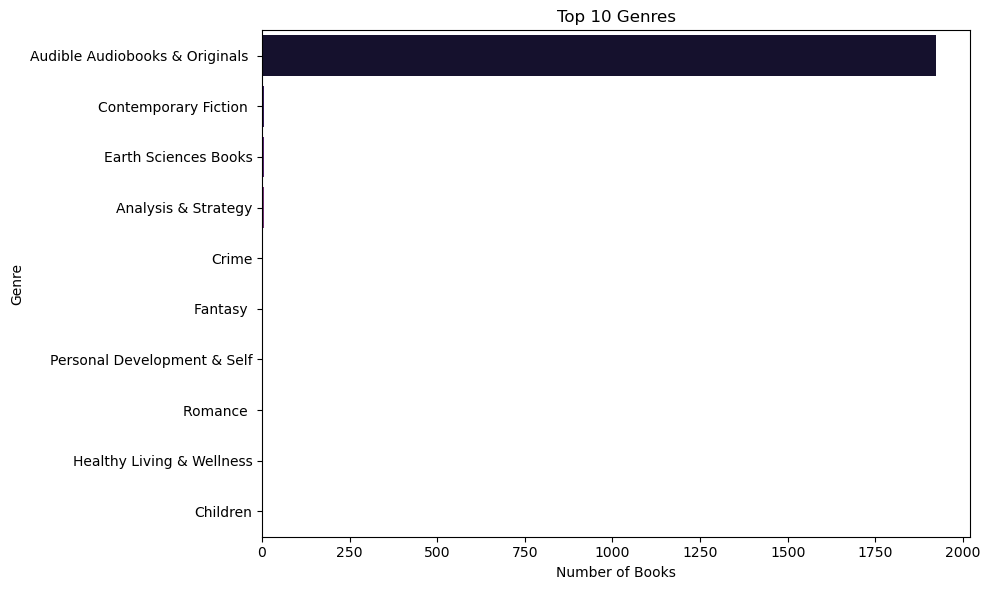

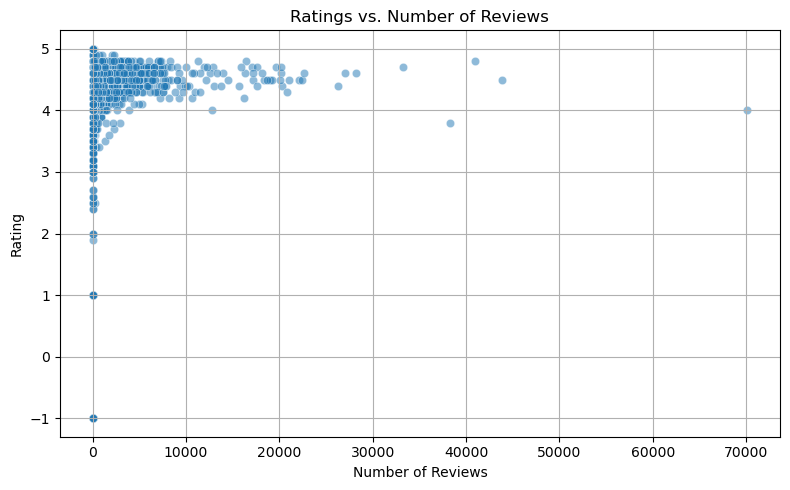

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(r"C:\Users\ratnakar\Downloads\cleaned_audible_catalog.csv")

plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Books')
plt.grid(True)
plt.tight_layout()
plt.show()

top_reviewed = df.sort_values(by='Number of Reviews', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_reviewed, x='Number of Reviews', y='Book Name', palette='viridis')
plt.title('Top 10 Most Reviewed Books')
plt.xlabel('Number of Reviews')
plt.ylabel('Book Name')
plt.tight_layout()
plt.show()

author_rating = df.groupby('Author').agg({'Rating': ['mean', 'count']})
author_rating.columns = ['Average Rating', 'Book Count']
author_rating = author_rating[author_rating['Book Count'] >= 5].sort_values(by='Average Rating', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=author_rating, x='Average Rating', y=author_rating.index, palette='coolwarm')
plt.title('Top 10 Authors by Average Rating (min 5 books)')
plt.tight_layout()
plt.show()

# Extract primary genre from 'Ranks and Genre'
df['Primary Genre'] = df['Ranks and Genre'].str.extract(r'in\s+([A-Za-z &]+)')

# Count top genres
genre_counts = df['Primary Genre'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='magma')
plt.title('Top 10 Genres')
plt.xlabel('Number of Books')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Number of Reviews', y='Rating', alpha=0.5)
plt.title('Ratings vs. Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ratnakar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



ðŸ“š Cluster 0 Sample Books:
                                            Book Name              Author
0   Think Like A Monk: The Secret Of How To Harnes...          Jay Shetty
7                    The Intelligent Investor Rev Ed.     Benjamin Graham
8   Rich Dad Poor Dad: What The Rich Teach Their K...  Robert T. Kiyosaki
9   The 5Am Club: Own Your Morning. Elevate Your L...        Robin Sharma
10            Influence: The Psychology Of Persuasion  Robert B. Cialdini

ðŸ“š Cluster 1 Sample Books:
                                            Book Name         Author
48  The Hard Thing About Hard Things: Building A B...   Ben Horowitz
51  Men Are From Mars, Women Are From Venus: The C...      John Gray
57                                        Hit Refresh  Satya Nadella
58                        A Suitable Boy (Dramatised)    Vikram Seth
59  Take Control Of Your Life: How To Silence Fear...    Mel Robbins

ðŸ“š Cluster 2 Sample Books:
                                            Book Nam

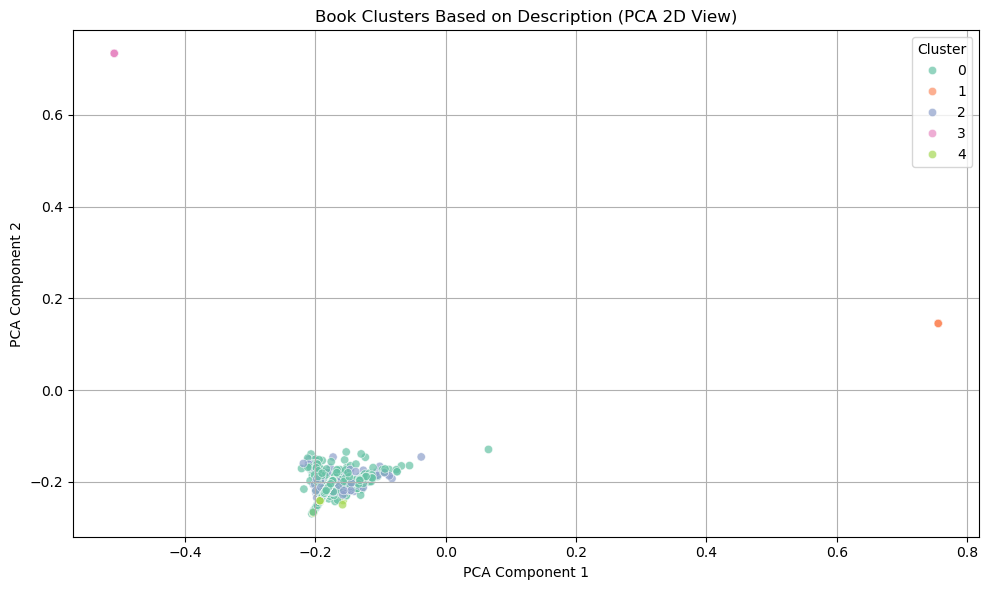

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load cleaned dataset
df = pd.read_csv(r"C:\Users\ratnakar\Downloads\cleaned_audible_catalog.csv")

# Step 1: Basic text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text)  # remove extra spaces
    return text.strip()

df['Cleaned_Description'] = df['Description'].apply(clean_text)

# Step 2: Remove stopwords
stop_words = set(stopwords.words('english'))
df['Cleaned_Description'] = df['Cleaned_Description'].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

# Step 3: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)  # limit to top 1000 words
X = vectorizer.fit_transform(df['Cleaned_Description'])

# Step 4: Apply KMeans Clustering
k = 5  # You can experiment with this
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Step 5: Explore cluster composition
for i in range(k):
    print(f"\nðŸ“š Cluster {i} Sample Books:")
    print(df[df['Cluster'] == i][['Book Name', 'Author']].head(5))

# Step 6: Optional 2D Visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='Set2', alpha=0.7)
plt.title("Book Clusters Based on Description (PCA 2D View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset with clusters
df = pd.read_csv(r"C:\Users\ratnakar\Downloads\cleaned_audible_catalog.csv")

# If you haven't added 'Cleaned_Description' and 'Cluster' yet:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

stop_words = set(stopwords.words('english'))
df['Cleaned_Description'] = df['Description'].apply(clean_text)
df['Cleaned_Description'] = df['Cleaned_Description'].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

# Step 1: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['Cleaned_Description'])

# Step 2: Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Content-Based Recommender
def recommend_books_content(title, top_n=5):
    if title not in df['Book Name'].values:
        return ["Book not found."]
    
    idx = df[df['Book Name'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    recommended_books = [df.iloc[i[0]]['Book Name'] for i in sim_scores]
    return recommended_books

# Step 4: Clustering-Based Recommender
def recommend_books_cluster(title, top_n=5):
    if title not in df['Book Name'].values:
        return ["Book not found."]
    
    target_cluster = df[df['Book Name'] == title]['Cluster'].values[0]
    cluster_books = df[df['Cluster'] == target_cluster]
    
    # Optionally sort by rating or reviews
    cluster_books = cluster_books.sort_values(by='Rating', ascending=False)
    
    recommendations = cluster_books[cluster_books['Book Name'] != title]['Book Name'].head(top_n).tolist()
    return recommendations

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ratnakar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [27]:
# app.py
import streamlit as st
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Load Data
@st.cache_data
def load_data():
    df = pd.read_csv(r"C:\Users\ratnakar\Downloads\cleaned_audible_catalog.csv")
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        return " ".join([word for word in text.split() if word not in stop_words])

    df['Cleaned_Description'] = df['Description'].apply(clean_text)
    return df

df = load_data()

# TF-IDF & Cosine Similarity (once only)
@st.cache_resource
def prepare_similarity(df):
    tfidf = TfidfVectorizer(max_features=1000)
    tfidf_matrix = tfidf.fit_transform(df['Cleaned_Description'])
    sim_matrix = cosine_similarity(tfidf_matrix)
    return tfidf_matrix, sim_matrix

tfidf_matrix, sim_matrix = prepare_similarity(df)

# Content-Based Recommender
def recommend_content(title, top_n=5):
    if title not in df['Book Name'].values:
        return ["Book not found."]
    idx = df[df['Book Name'] == title].index[0]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    return [df.iloc[i[0]]['Book Name'] for i in sim_scores]

# Cluster-Based Recommender
def recommend_cluster(title, top_n=5):
    if title not in df['Book Name'].values:
        return ["Book not found."]
    cluster_id = df[df['Book Name'] == title]['Cluster'].values[0]
    cluster_books = df[(df['Cluster'] == cluster_id) & (df['Book Name'] != title)]
    top_books = cluster_books.sort_values(by='Rating', ascending=False).head(top_n)
    return top_books['Book Name'].tolist()

# Streamlit UI
st.title("ðŸ“š Book Recommendation App")
st.markdown("Get personalized book recommendations based on content or clusters.")

book_list = df['Book Name'].sort_values().unique().tolist()
selected_book = st.selectbox("Choose a book you liked:", book_list)

model_choice = st.radio("Select Recommendation Method:", ["Content-Based", "Cluster-Based"])

if st.button("Get Recommendations"):
    if model_choice == "Content-Based":
        recs = recommend_content(selected_book)
    else:
        recs = recommend_cluster(selected_book)

    st.subheader("ðŸ“– Recommended Books:")
    for book in recs:
        st.markdown(f"- {book}")

# Optional EDA

with st.expander("ðŸŽ¯ Top Authors by Avg Rating"):
    top_authors = df.groupby('Author')['Rating'].mean().sort_values(ascending=False).head(10)
    st.bar_chart(top_authors)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ratnakar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-06-16 20:54:52.893 No runtime found, using MemoryCacheStorageManager
2025-06-16 20:54:52.950 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 20:54:52.952 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 20:54:52.954 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 20:54:52.955 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 20:54:52.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 20:54:52.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06